In [2]:
# custom_objects downloading
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K
import numpy as np

@tf.keras.utils.register_keras_serializable()
class RepeatChannels(Layer):
    def __init__(self, **kwargs):
        super(RepeatChannels, self).__init__(**kwargs)

    def call(self, inputs):
        # Assuming the repeat operation repeats across channels
        return K.repeat_elements(inputs, rep=3, axis=-1)

    def get_config(self):
        config = super(RepeatChannels, self).get_config()
        return config

@tf.keras.utils.register_keras_serializable()
def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = K.sum(y_true * y_pred)
        union = K.sum(y_true) + K.sum(y_pred) - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

@tf.keras.utils.register_keras_serializable()
def dice_coef(y_true, y_pred, smooth=1e-6):
    """
    Compute the Dice coefficient, a measure of overlap between two samples.
    """
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)

    intersection = tf.reduce_sum(y_true * y_pred)
    dice = (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)
    return dice

@tf.keras.utils.register_keras_serializable()
def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

@tf.keras.utils.register_keras_serializable()
def bce_dice_loss(y_true, y_pred):
    # Binary Cross-Entropy
    bce_loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    # Dice Loss
    intersection = tf.reduce_sum(y_true * y_pred)
    dice_loss = 1 - (2. * intersection + 1) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + 1)
    # Combine both losses
    return bce_loss + dice_loss

# Load models with custom objects
from tensorflow.keras.models import load_model

custom_objects = {
    'RepeatChannels': RepeatChannels,
    'iou': iou,
    'dice_coef': dice_coef,
    'dice_loss': dice_loss,
    'bce_dice_loss': bce_dice_loss
}

/Users/ammaster10/Documents/Github/Year4/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [1]:
DeepLabV3 = "/Users/ammaster10/Documents/Github/Year4/CNVresearch/Models/deeplabv3_plus_ultra_model_2025_02_10_01_37_48.keras"

In [26]:
def preprocess_noise(image, method='median', kernel_size=3):
    if kernel_size % 2 == 0 or kernel_size < 1:
        raise ValueError("Kernel size must be an odd integer greater than 1.")

    if method == 'gaussian':
        # Apply Gaussian Blur
        denoised = cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)
    elif method == 'median':
        # Apply Median Filter
        denoised = cv2.medianBlur(image, kernel_size)
    elif method == 'bilateral':
        # Apply Bilateral Filter
        denoised = cv2.bilateralFilter(image, kernel_size, 75, 75)
    else:
        raise ValueError("Unsupported denoising method. Use 'gaussian', 'median', or 'bilateral'.")

    return denoised


In [ ]:
# Parese Coco
def parse_coco_json(json_file, image_dir):
    """
    Parses the COCO JSON file and returns a dictionary of image masks.

    Args:
        json_file: Path to the COCO JSON file.
        image_dir: Directory containing the images.

    Returns:
        Dictionary with image filenames as keys and corresponding masks as values.
    """
    import json
    from pycocotools import mask as maskUtils
    from PIL import ImageDraw

    with open(json_file, 'r') as f:
        coco_data = json.load(f)

    annotations = {}
    image_data = {img['id']: img for img in coco_data['images']}

    for ann in coco_data['annotations']:
        img_info = image_data[ann['image_id']]
        img_filename = img_info['file_name']
        width, height = img_info['width'], img_info['height']

        if 'segmentation' in ann:
            segmentation = ann['segmentation']
            mask = segmentation_to_mask(segmentation, width, height)
            resized_mask = np.array(Image.fromarray(mask).resize((256, 256), Image.NEAREST))
            annotations[img_filename] = resized_mask

    return annotations

def segmentation_to_mask(segmentation, width, height):
    """
    Converts COCO segmentation to a binary mask.

    Args:
        segmentation: COCO segmentation data (RLE or polygon).
        width: Image width.
        height: Image height.

    Returns:
        Binary mask as a numpy array.
    """
    from pycocotools import mask as maskUtils
    from PIL import Image, ImageDraw

    if isinstance(segmentation, list):  # Polygon format
        mask = np.zeros((height, width), dtype=np.uint8)
        for polygon in segmentation:
            poly = np.array(polygon).reshape((-1, 2))
            img = Image.new('L', (width, height), 0)
            ImageDraw.Draw(img).polygon([tuple(p) for p in poly], outline=1, fill=1)
            mask = np.array(img, dtype=np.uint8)
        return mask
    elif isinstance(segmentation, dict):  # RLE format
        rle = maskUtils.frPyObjects(segmentation, height, width)
        mask = maskUtils.decode(rle)
        return mask
    return np.zeros((height, width), dtype=np.uint8)

In [3]:
import cv2
from tensorflow.keras.models import load_model

import matplotlib.pyplot as plt

# Load the DeepLabV3+ model with custom objects
model = load_model(DeepLabV3, custom_objects=custom_objects)

# Print model summary to verify it loaded correctly
print(f"Model loaded successfully from: {DeepLabV3}")
# model.summary()

Model loaded successfully from: /Users/ammaster10/Documents/Github/Year4/CNVresearch/Models/deeplabv3_plus_ultra_model_2025_02_10_01_37_48.keras


In [ ]:
import os
import cv2  # You might need to run: pip install opencv-python
import numpy as np
from PIL import Image
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model # To load your model
# The following imports are for the COCO functions, which are included but not used in the main loop
import json
from pycocotools import mask as maskUtils
from PIL import ImageDraw
from pycocotools.coco import COCO

def run_inference_and_save_predictions(model, image_dir, coco_json_path, output_dir, target_size=(256, 256)):
    os.makedirs(output_dir, exist_ok=True)
    coco = COCO(coco_json_path)
    img_ids = coco.getImgIds()
    print(f"Found {len(img_ids)} image entries in the JSON. Processing with target_size={target_size}...")

    for img_id in tqdm(img_ids, desc="Predicting masks"):
        img_info = coco.loadImgs(img_id)[0]
        filename = img_info['file_name']

        image_path = os.path.join(image_dir, filename)

        try:
            if not os.path.exists(image_path):
                print(f"\nWarning: File not found, skipping -> {image_path}")
                continue
            
            # This will now use the corrected target_size (e.g., 512x512)
            img = load_img(image_path, color_mode='grayscale', target_size=target_size)
            
            img_array = img_to_array(img)
            img_uint8 = img_array.astype(np.uint8)
            img_denoised = preprocess_noise(img_uint8, method='median', kernel_size=3)
            img_normalized = img_denoised.astype(np.float32) / 255.0
            model_input = np.expand_dims(img_normalized, axis=0)

            predicted_mask = model.predict(model_input, verbose=0)[0]
            binary_mask = (predicted_mask > 0.5).astype(np.uint8)
            output_image_array = np.squeeze(binary_mask) * 255
            output_image = Image.fromarray(output_image_array, mode='L')
            
            base_name = os.path.splitext(filename)[0]
            output_path = os.path.join(output_dir, f"{base_name}_predicted_mask.png")
            output_image.save(output_path)

        except Exception as e:
            print(f"\nError processing {filename}: {e}")

    print(f"\nDone! All predicted masks saved to: {output_dir}")


In [34]:
image_dir = "/Users/ammaster10/Documents/Github/Year4/CNVresearch/Validation/340_Folder/340_Test"
coco_json_path = "/Users/ammaster10/Documents/Github/Year4/CNVresearch/Validation/340_Folder/subset_340.json"
output_dir = "/Users/ammaster10/Documents/Github/Year4/CNVresearch/Validation/340_Folder/GVF_Ready"

run_inference_and_save_predictions(model, image_dir,coco_json_path=coco_json_path, output_dir=output_dir, target_size=(512, 512))

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
Found 340 image entries in the JSON. Processing with target_size=(512, 512)...


Predicting masks:   0%|          | 0/340 [00:00<?, ?it/s]2025-08-16 20:42:04.916741: I external/local_xla/xla/service/service.cc:163] XLA service 0x31390d680 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2025-08-16 20:42:04.916760: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): Host, Default Version
2025-08-16 20:42:05.001688: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1755351725.743988 1102705 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
/var/folders/q3/rnsm0fg975ld64pvb5fc5dmm0000gn/T/ipykernel_79864/1375145498.py:43: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  output_image = Image.fromarray(output_image_array, mode='L')
Predicting masks: 100%|██████████| 340/340


✅ Done! All predicted masks saved to: /Users/ammaster10/Documents/Github/Year4/CNVresearch/Validation/340_Folder/GVF_Ready


In [ ]:
from sklearn.metrics import f1_score
from skimage import io, img_as_float
from skimage.filters import gaussian
from skimage.transform import resize
import morphsnakes
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def morphsnakes_eval_folder(image_path_folder, mask_path_folder, cocojson_file):
    # Adjust amount of images processed 
    cout = 7
    annotations = parse_coco_json(cocojson_file, image_path_folder)
    image_files = sorted([f for f in os.listdir(image_path_folder) if f.lower().endswith(('.jpeg', '.jpg', '.png'))])

    f1_results = {}  # {filename_key: f1_score}

    for filename_key in image_files:
        if cout <= 0:
            break
        try:
            image_path = os.path.join(image_path_folder, filename_key)
            base_name = os.path.splitext(filename_key)[0]
            pred_mask_path = os.path.join(mask_path_folder, f"{base_name}_predicted_mask.png")

            if not os.path.exists(pred_mask_path):
                print(f"❌ Skipping {filename_key} — predicted mask not found.")
                continue

            # Load image + predicted mask
            original = img_as_float(io.imread(image_path, as_gray=True))
            mask = io.imread(pred_mask_path, as_gray=True) > 0.5

            if original.shape != mask.shape:
                original_resized = resize(original, mask.shape, anti_aliasing=True)
            else:
                original_resized = original

            smoothed = gaussian(original_resized, sigma=1.0)

            init_ls = mask.astype(float)
            refined_mask_array = morphsnakes.morphological_chan_vese(
                smoothed,
                iterations=75,
                init_level_set=init_ls,
                smoothing=3,
                lambda1=1.25,
                lambda2=0.8
            )
            refined_mask = refined_mask_array > 0.5

            # Ground truth from COCO
            ground_truth_mask = annotations.get(filename_key, np.zeros(mask.shape, dtype=np.uint8))

            # Add these inside your loop
            # Resize ground truth to match predicted mask shape
            if ground_truth_mask.shape != mask.shape:
                ground_truth_resized_for_pred = np.array(
                    Image.fromarray(ground_truth_mask).resize(mask.shape[::-1], Image.NEAREST)
                )
            else:
                ground_truth_resized_for_pred = ground_truth_mask

            if ground_truth_mask.shape != refined_mask.shape:
                ground_truth_resized_for_refined = np.array(
                    Image.fromarray(ground_truth_mask).resize(refined_mask.shape[::-1], Image.NEAREST)
                )
            else:
                ground_truth_resized_for_refined = ground_truth_mask

            # Flatten
            y_true_pred = ground_truth_resized_for_pred.flatten()
            y_pred_initial = mask.flatten().astype(np.uint8)

            y_true_refined = ground_truth_resized_for_refined.flatten()
            y_pred_refined = refined_mask.flatten().astype(np.uint8)

            # Compute F1
            if y_true_pred.sum() == 0 and y_pred_initial.sum() == 0:
                f1_initial = 1.0
            else:
                f1_initial = f1_score(y_true_pred, y_pred_initial, average='binary')

            if y_true_refined.sum() == 0 and y_pred_refined.sum() == 0:
                f1_refined = 1.0
            else:
                f1_refined = f1_score(y_true_refined, y_pred_refined, average='binary')

            # Store both F1s
            f1_results[filename_key] = {
                "Initial": f1_initial,
                "Refined": f1_refined
            }
            # Plot result
            plt.figure(figsize=(15, 5))
            plt.suptitle(
                f"GVF Evaluation: {filename_key}\nF1 Initial: {f1_initial:.4f} | F1 Refined: {f1_refined:.4f}",
                fontsize=13
            )
            plt.subplot(1, 4, 1)
            plt.imshow(original_resized, cmap='gray')
            plt.title("Original")
            plt.axis('off')

            plt.subplot(1, 4, 2)
            plt.imshow(mask, cmap='gray')
            plt.title("Initial Pred")
            plt.axis('off')

            plt.subplot(1, 4, 3)
            plt.imshow(refined_mask, cmap='gray')
            plt.title("Refined (Chan-Vese)")
            plt.axis('off')

            plt.subplot(1, 4, 4)
            plt.imshow(ground_truth_resized_for_refined, cmap='gray')
            plt.title("Ground Truth")
            plt.axis('off')

            plt.tight_layout()
            plt.show()

            cout -= 1
        except Exception as e:
            print(f"Error processing {filename_key}: {e}")

    return f1_results

In [ ]:
import json
import csv
import numpy as np
from pathlib import Path
from typing import Optional

def _normalize_results(raw: dict, source: str) -> dict:
    """
    Make result keys uniform across methods.
    Returns: {filename: {'f1_initial': float, 'f1_refined': float}}
    """
    norm = {}
    for k, v in raw.items():
        if source == "crf":
            fi = float(v.get("f1_initial", np.nan))
            fr = float(v.get("f1_refined", np.nan))
        else:  # morphsnakes
            fi = float(v.get("Initial", np.nan))
            fr = float(v.get("Refined", np.nan))
        norm[k] = {"f1_initial": fi, "f1_refined": fr}
    return norm

def _summarize(norm: dict) -> dict:
    """Compute simple summary stats."""
    fins  = [v["f1_initial"] for v in norm.values() if not np.isnan(v["f1_initial"])]
    frefs = [v["f1_refined"] for v in norm.values() if not np.isnan(v["f1_refined"])]
    return {
        "n": len(norm),
        "n_with_f1": len(set([*[k for k,v in norm.items() if not np.isnan(v['f1_initial'])],
                             *[k for k,v in norm.items() if not np.isnan(v['f1_refined'])]])),
        "mean_f1_initial": float(np.mean(fins)) if fins else float("nan"),
        "mean_f1_refined": float(np.mean(frefs)) if frefs else float("nan"),
    }

def _maybe_save(norm: dict, out_dir: Optional[str]):
    if not out_dir:
        return
    out = Path(out_dir); out.mkdir(parents=True, exist_ok=True)
    # JSON
    (out / "per_image_f1.json").write_text(json.dumps(norm, indent=2))
    # CSV
    with (out / "per_image_f1.csv").open("w", newline="") as f:
        w = csv.writer(f)
        w.writerow(["filename", "f1_initial", "f1_refined"])
        for k, v in norm.items():
            w.writerow([k, v["f1_initial"], v["f1_refined"]])

def evaluate(
    method: str,
    image_path_folder: str,
    mask_path_folder: str,
    prob_map_folder: Optional[str] = None,
    cocojson_file: Optional[str] = None,
    limit: Optional[int] = None,
    save_refined_to: Optional[str] = None,
    show: bool = True,
    save_results_to: Optional[str] = None,
) -> dict:
    """
    Unified evaluation entrypoint.

    method: "crf" or "morphsnakes"
    - For "crf": prob_map_folder is required.
    - For "morphsnakes": prob_map_folder is ignored.

    Returns:
      {
        'per_image': {filename: {'f1_initial':..., 'f1_refined':...}},
        'summary': {'n':..., 'mean_f1_initial':..., 'mean_f1_refined':...}
      }
    """
    method = method.lower().strip()
    if method == "crf":
        if prob_map_folder is None:
            raise ValueError("CRF evaluation requires prob_map_folder.")
        raw = crf_eval_folder(
            image_path_folder=image_path_folder,
            mask_path_folder=mask_path_folder,
            prob_map_folder=prob_map_folder,
            cocojson_file=cocojson_file,
            limit=limit,
            save_refined_to=save_refined_to,
            show=show
        )
        norm = _normalize_results(raw, source="crf")

    elif method in ("morph", "morphsnakes", "chanvese", "gvf"):
        raw = morphsnakes_eval_folder(
            image_path_folder=image_path_folder,
            mask_path_folder=mask_path_folder,
            cocojson_file=cocojson_file
        )
        norm = _normalize_results(raw, source="morphsnakes")

    else:
        raise ValueError(f"Unknown method '{method}'. Use 'crf' or 'morphsnakes'.")

    _maybe_save(norm, save_results_to)
    summary = _summarize(norm)

    print(f"[{method.upper()}] images: {summary['n']}, "
          f"mean F1 (initial): {summary['mean_f1_initial']:.4f}, "
          f"mean F1 (refined): {summary['mean_f1_refined']:.4f}")

    return {"per_image": norm, "summary": summary}

TypeError: unsupported operand type(s) for |: 'type' and 'NoneType'

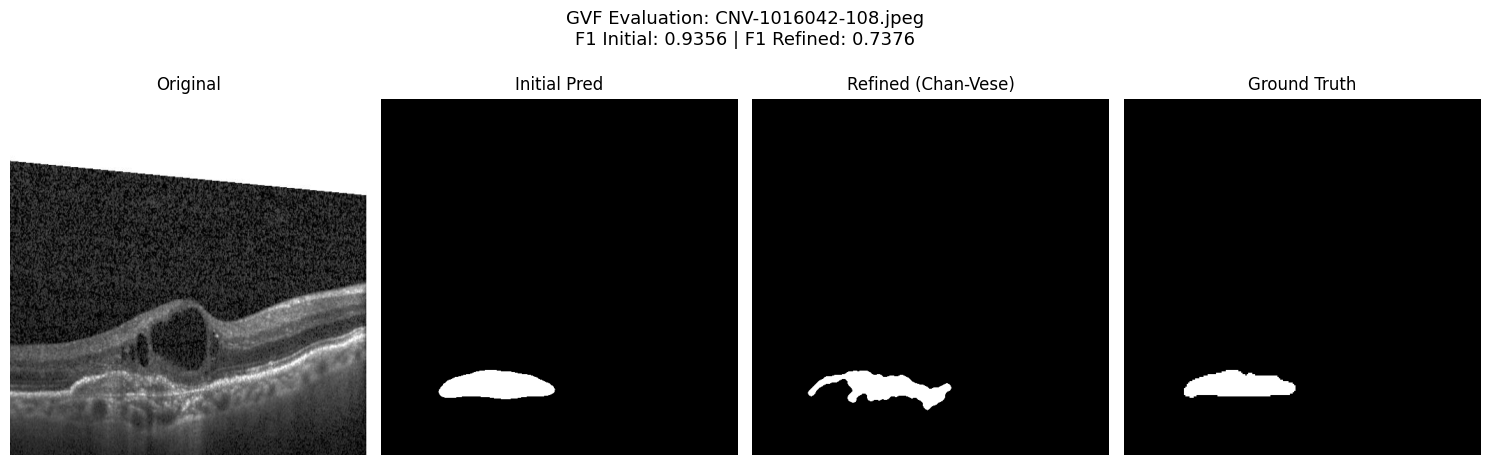

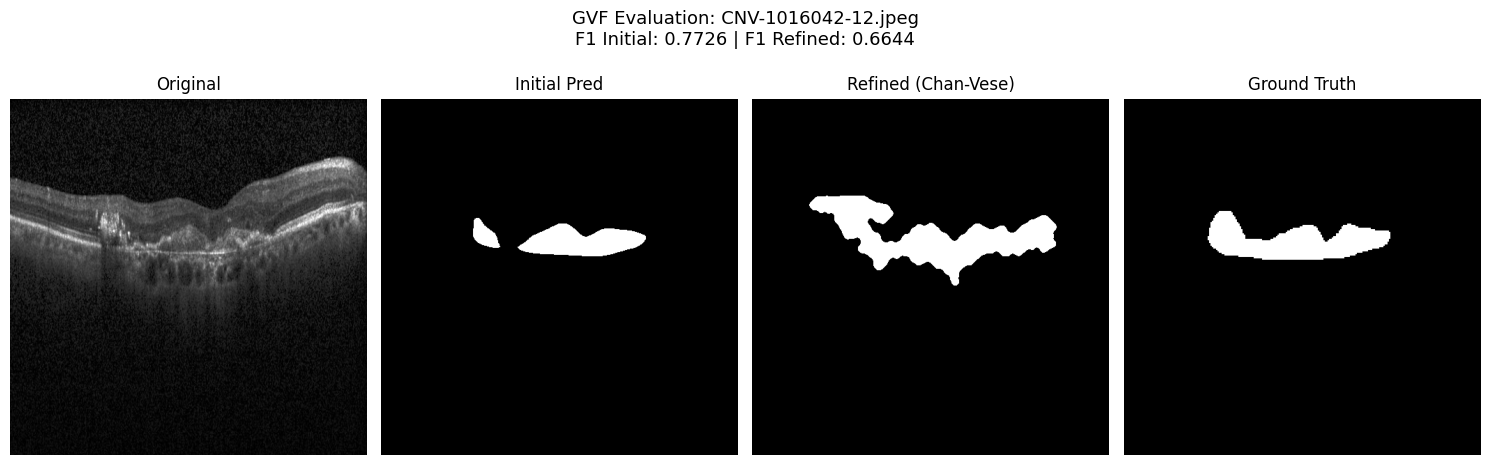

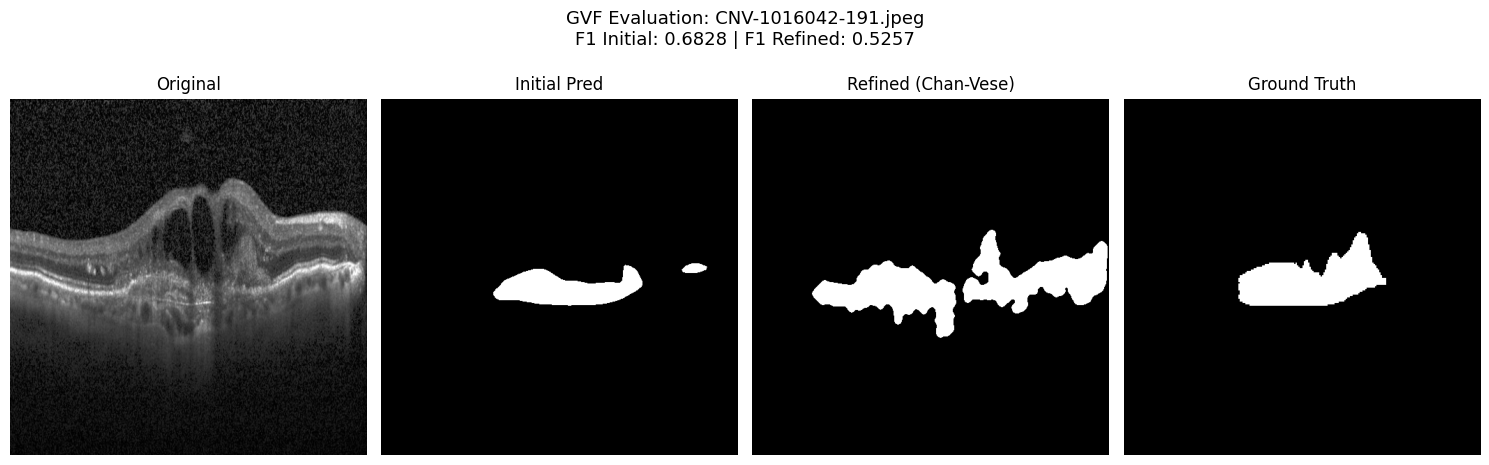

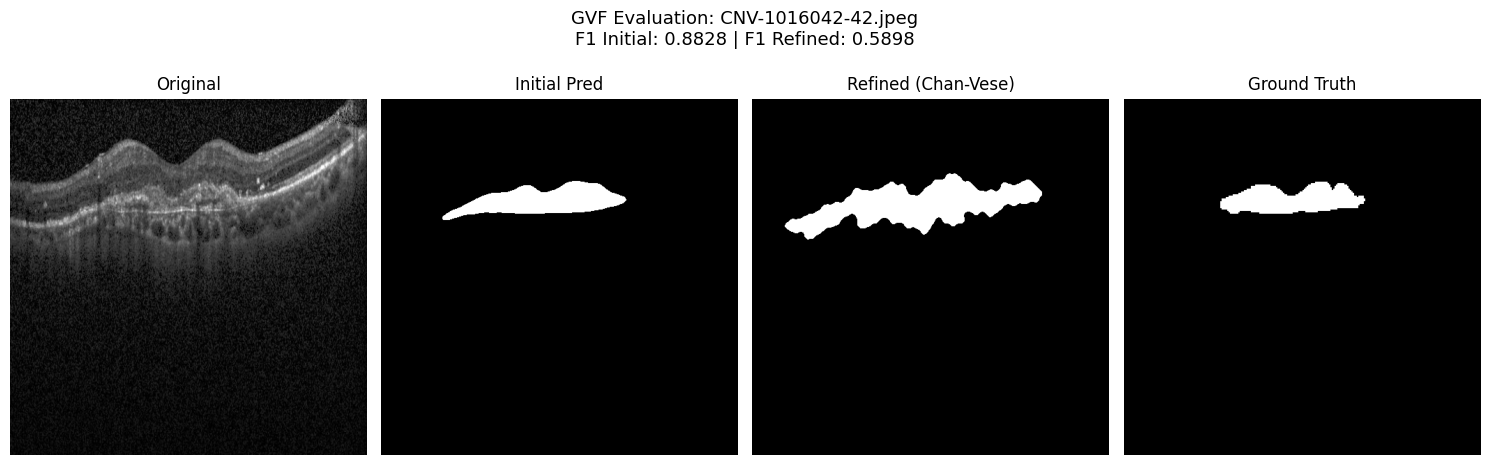

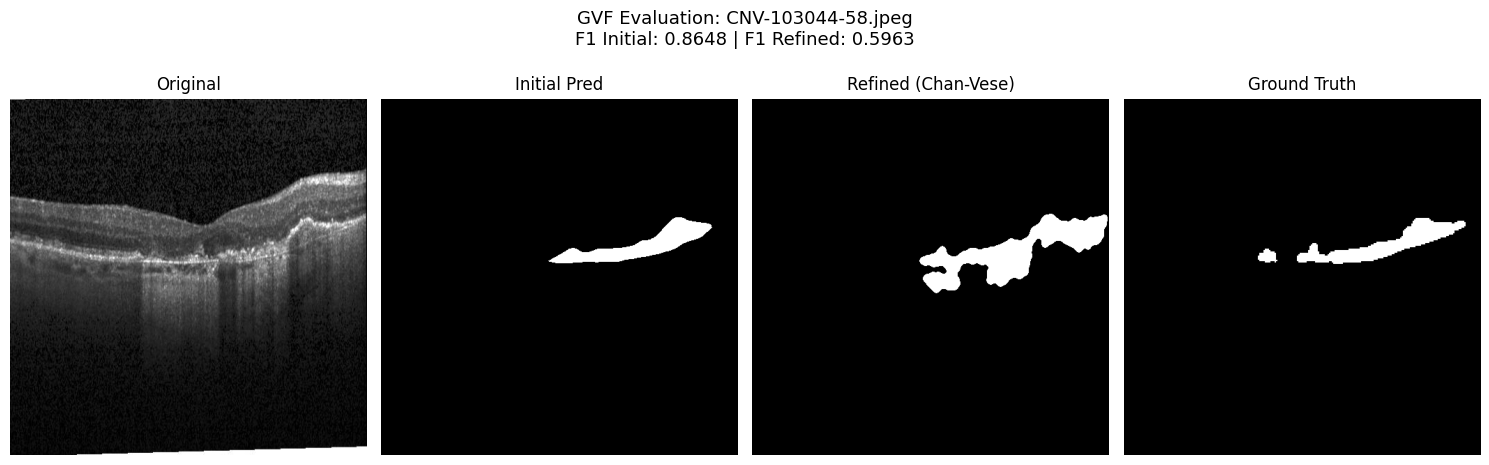

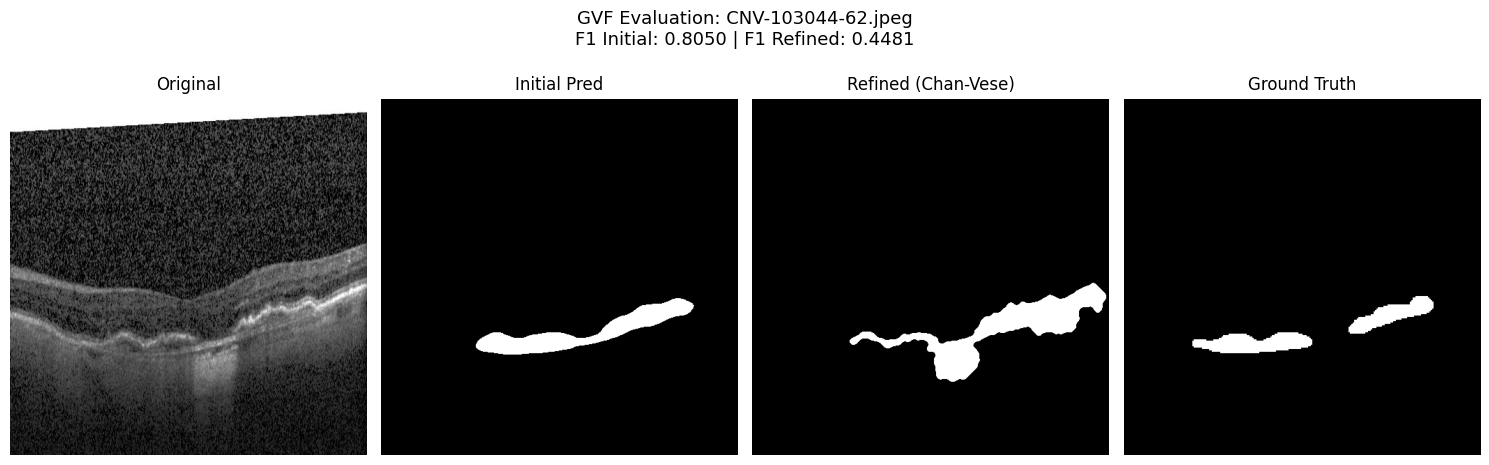

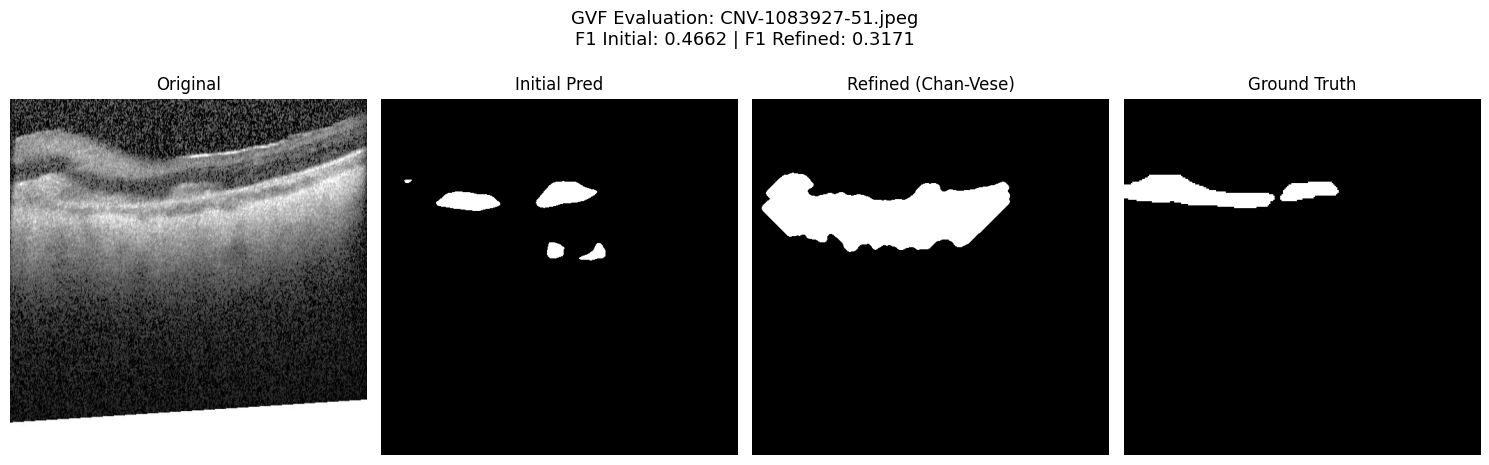

{'CNV-1016042-108.jpeg': {'Initial': 0.935590421139554,
  'Refined': 0.7376362112321878},
 'CNV-1016042-12.jpeg': {'Initial': 0.7725856697819314,
  'Refined': 0.6644272757809876},
 'CNV-1016042-191.jpeg': {'Initial': 0.6828019081094652,
  'Refined': 0.5257077166259521},
 'CNV-1016042-42.jpeg': {'Initial': 0.8828059367124055,
  'Refined': 0.5898289623717218},
 'CNV-103044-58.jpeg': {'Initial': 0.8648498845265589,
  'Refined': 0.5963286187180259},
 'CNV-103044-62.jpeg': {'Initial': 0.8049786525797814,
  'Refined': 0.4481224224006946},
 'CNV-1083927-51.jpeg': {'Initial': 0.4661642205474018,
  'Refined': 0.3171287738755391}}

In [21]:
morphsnakes_eval_folder(
    image_path_folder="/Users/ammaster10/Documents/Github/Year4/CNVresearch/Validation/340_Folder/340_Test/",
    mask_path_folder="/Users/ammaster10/Documents/Github/Year4/CNVresearch/Validation/340_Folder/GVF_Ready/",
    cocojson_file="/Users/ammaster10/Documents/Github/Year4/CNVresearch/Validation/340_Folder/subset_340.json"
)